In [31]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from features import ensembleFeature
import itertools
from utils import metricsCal
from thundersvm import SVC
from sklearn.model_selection import KFold
import pymrmr

In [2]:
##将序列转化为词向量用到的函数
def fa_seq(filepath):
    f = open(filepath,'r')
    x = []
    for i in f:
        x.append(i)
    seq = []
    for i in range(len(x)):
        if i%2==1:
            seq.append(x[i][:-1])
    return seq

In [3]:
train_seq = fa_seq("data/Mouse/mouse_train.fasta")
test_seq = fa_seq("data/Mouse/mouse_indep.fasta")
trainPos_seq = train_seq[0:int(len(train_seq)/2)]
trainNeg_seq = train_seq[int(len(train_seq)/2):]
testPos_seq = test_seq[0:int(len(test_seq)/2)]
testNeg_seq = test_seq[int(len(test_seq)/2):]
trainLabel = np.append(np.ones(int(len(train_seq)/2)),np.zeros(int(len(train_seq)-len(train_seq)/2)),axis=0)
testLabel = np.append(np.ones(int(len(test_seq)/2)),np.zeros(int(len(test_seq)-len(test_seq)/2)),axis=0)

In [111]:
#首先把所有特征表示出来
#值
trainPos,trainNeg,testPos,testNeg = ensembleFeature.PSKP(trainPos_seq,trainNeg_seq,testPos_seq,testNeg_seq,1) #3代表PSTP，2代表PSDP，1代表PSNP
trainData_PSNP = np.vstack((trainPos,trainNeg))
testData_PSNP = np.vstack((testPos,testNeg))
trainPos,trainNeg,testPos,testNeg = ensembleFeature.PSKP(trainPos_seq,trainNeg_seq,testPos_seq,testNeg_seq,2) #3代表PSTP，2代表PSDP，1代表PSNP
trainData_PSDP = np.vstack((trainPos,trainNeg))
testData_PSDP = np.vstack((testPos,testNeg))
trainPos,trainNeg,testPos,testNeg = ensembleFeature.PSKP(trainPos_seq,trainNeg_seq,testPos_seq,testNeg_seq,3) #3代表PSTP，2代表PSDP，1代表PSNP
trainData_PSTP = np.vstack((trainPos,trainNeg))
testData_PSTP = np.vstack((testPos,testNeg))
trainData_PSKP = np.hstack((trainData_PSNP,trainData_PSDP,trainData_PSTP))
testData_PSKP = np.hstack((testData_PSNP,testData_PSDP,testData_PSTP))



trainPos,trainNeg,testPos,testNeg = ensembleFeature.PSCP(trainPos_seq,trainNeg_seq,testPos_seq,testNeg_seq,0)
trainData_PSCP_0 = np.vstack((trainPos,trainNeg))
testData_PSCP_0 = np.vstack((testPos,testNeg))
trainPos,trainNeg,testPos,testNeg = ensembleFeature.PSCP(trainPos_seq,trainNeg_seq,testPos_seq,testNeg_seq,1)
trainData_PSCP_1 = np.vstack((trainPos,trainNeg))
testData_PSCP_1 = np.vstack((testPos,testNeg))
trainPos,trainNeg,testPos,testNeg = ensembleFeature.PSCP(trainPos_seq,trainNeg_seq,testPos_seq,testNeg_seq,2)
trainData_PSCP_2 = np.vstack((trainPos,trainNeg))
testData_PSCP_2 = np.vstack((testPos,testNeg))

trainData_PSCP = np.hstack((trainData_PSCP_0,trainData_PSCP_1,trainData_PSCP_2))
testData_PSCP = np.hstack((testData_PSCP_0,testData_PSCP_1,testData_PSCP_2))

trainPos,trainNeg,testPos,testNeg = ensembleFeature.BPB(trainPos_seq,trainNeg_seq,testPos_seq,testNeg_seq)
trainData_BPB = np.vstack((trainPos,trainNeg))
testData_BPB = np.vstack((testPos,testNeg))

trainData_KNN = np.array(pd.read_csv("features/KNN_value_train.csv").iloc[:,1:])
testData_KNN = np.array(pd.read_csv("features/KNN_value_test.csv").iloc[:,1:])

trainData_origin = np.hstack((trainData_PSKP,trainData_PSCP,trainData_BPB,trainData_KNN))
testData = np.hstack((testData_PSKP,testData_PSCP,testData_BPB,testData_KNN))

In [ ]:
from scipy.stats import shapiro

# 假设数据存储在变量data中，其中行表示观测样本，列表示特征
# 首先需要对每个特征进行测试
for i in range(data.shape[1]):
    stat, p = shapiro(data[:,i])
    alpha = 0.05
    if p > alpha:
        print('Feature %d looks Gaussian (fail to reject H0)' % i)
    else:
        print('Feature %d does not look Gaussian (reject H0)' % i)


# 二级结构特征

In [14]:
def file_va(filename):
    f = open(filename,"rb")
    m=0
    name = []
    seq = []
    struc = []
    for i in f:
        #print(i)
        m+=1
        if m>2 and (m-2)%3==1:
            name.append(str(i[1:-1],'utf-8'))
        if m>3 and (m-2)%3==2:
            seq.append(str(i[:-1],'utf-8'))
        if m>3 and (m-2)%3==0:
            struc.append(str(i,'utf-8')[:41])
    return name,seq,struc

def RNAfold_dot(filename):
    f = open(filename,"rb")
    m = 0
    struc = []
    seq = []
    for i in f:
        m+=1
        if m%6==3:
            struc.append(str(i[0:41],'utf-8'))
        if m%6==2:
            seq.append(str(i[0:41],'utf-8'))
    return seq,struc

def struc_01(data):
    x = np.zeros(len(data)*2).reshape(-1,2)
    for i in range(len(data)):
        if data[i]=="(":
            x[i][0]=1
        elif data[i]==")":
            x[i][1]=1
    return x

def struc_01_8(data):
    x = np.zeros((len(data)-2)*8).reshape(-1,8)
    for i in range(len(data)-2):
        mm = 0
        if data[i]=="(" or data[i]==")":
            mm+=4
        if data[i+1]=="(" or data[i]==")":
            mm+=2
        if data[i+2]=="(" or data[i]==")":
            mm+=1
        x[i][mm]=1
    return x

In [15]:
def judge_kuohao(struc,index):
    for i in range(len(struc)-index-1):
        if struc[index+i+1]=="(":
            return 1  #左
        if struc[index+i+1]==")":
            return 2  #右
        if index+i+1 == len(struc)-1:
            return 0  #点

def judge_left_left(struc,index,li):  #判断左左情况下第一个配对的右
    ora_index = 0  #记录第二个左的index
    for i in range(len(struc)-index-1):
#         print(li)
#         print(ora_index)
        if struc[i+index+1]=="(" and ora_index==0:
            li.append(i+index+1)
            ora_index=i+index+1
        if struc[i+index+1]=="(" and ora_index!=0:
            li.append(i+index+1)
        if struc[i+index+1]==")":
            if li.pop()==ora_index: #判断是否配对
                if struc[i+index+2]==")":
                    return 3 #凸环
                if struc[i+index+2]=="(":
                    return 4 #多分支环
                if struc[i+index+2]=="." and judge_kuohao(struc,i+index+1)==2:
                    return 5 #内环
                if struc[i+index+2]=="." and judge_kuohao(struc,i+index+1)==1:
                    return 4 #多分支环 连接至少两个茎区

def struc_sec(struc):
    state = 0
    sec = []
    left_index = []
    for i in range(len(struc)):
        if struc[i]=="." and state == 0:
            sec.append(0) #自由单链
        if struc[i]=="(":
            state=1       #前面是左括号
            left_index.append(i)
            sec.append(1) #茎区
        if struc[i]==")":
            state=2      #前面是右括号
            left_index.pop()
            sec.append(1) #茎区
        if struc[i]=="." and state==1:
            if judge_kuohao(struc,i)==2:
                sec.append(2)  #发卡环  左括号接点接右括号
            if judge_kuohao(struc,i)==1:  #左括号后接左括号
                sec.append(judge_left_left(struc,i,left_index))
                
        if struc[i]=="." and state==2:
            if judge_kuohao(struc,i)==0: #右括号后面无
                sec.append(0) #自由单链
            if judge_kuohao(struc,i)==1: #右括号后面接左括号
                sec.append(4)  #多分支环
            if judge_kuohao(struc,i)==2: #右括号后面接右括号   #对应前面左左的情况，看左左是否有空点
                #因为此处知道右括号的位置，所以直接跳转到对应的第一个左括号（第二个已被pop），比较第二个左括号前面的左括号中间有没有点
                if struc[left_index[len(left_index)-1]+1]==".": #左侧有点，内环
                    sec.append(5)
                if struc[left_index[len(left_index)-1]+1]=="(": #左侧直接左括号，凸环
                    sec.append(3)
    return sec

In [132]:
train_name,train_seq,train_struc = file_va("data/mouse_train.log")
trainPosLabel = np.ones(int(len(train_seq)/2))
trainNegLabel = np.zeros(int(len(train_seq)/2))
trainLabel = np.append(trainPosLabel,trainNegLabel)
#获取01二级结构表示
trainData = []
for i in range(len(train_struc)):
    trainData.append(struc_01(train_struc[i]))
trainData = np.array(trainData)
        
#与单热编码结合
trainData_origin = np.append(trainData,ensembleFeature.Binary(train_seq),axis=2).reshape(trainData.shape[0],-1)

# 组成成分特征

In [100]:
trainData_EIIP = ensembleFeature.EIIP(train_seq)

trainData_PseEIIP = ensembleFeature.PseEIIP(train_seq)

trainData_PCP = ensembleFeature.PCP(train_seq)

trainData_NCPA = ensembleFeature.NCPA(train_seq)
trainData_NCPA = trainData_NCPA.reshape(trainData_NCPA.shape[0],-1)

trainData_DBPF = ensembleFeature.DBPF(train_seq)
trainData_DBPF = trainData_DBPF.reshape(trainData_DBPF.shape[0],-1)

trainData_origin = np.concatenate((trainData_EIIP,trainData_PseEIIP,trainData_PCP,trainData_NCPA,trainData_DBPF),axis=1)

In [101]:
trainData_com = trainData_origin

In [34]:
#ICA降维
from sklearn.decomposition import FastICA
ica = FastICA(n_components= 100).fit(trainData_origin)
trainData = ica.transform(trainData_origin)

In [133]:
# from scipy.stats import shapiro

# # 假设数据存储在变量data中，其中行表示观测样本，列表示特征
# # 首先需要对每个特征进行测试
# for i in range(trainData_origin.shape[1]):
#     stat, p = shapiro(trainData_origin[:,i])
#     alpha = 0.05
#     print(p)
#     if p > alpha:
#         print('Feature %d looks Gaussian (fail to reject H0)' % i)
#     else:
#         print('Feature %d does not look Gaussian (reject H0)' % i)

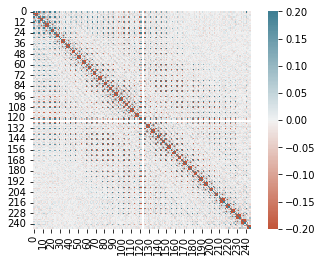

In [134]:
import numpy as np
import pandas as pd
import seaborn as sns


# 计算Spearman相关性系数
corr_matrix = pd.DataFrame(trainData_origin).corr(method='spearman')

# 绘制热力图
sns.heatmap(corr_matrix, vmin=-0.2, vmax=0.2, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.savefig("Result/Secondary_Spearman.jpg",dpi=300)

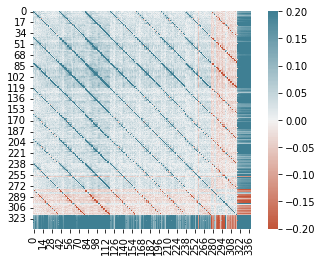

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns


# 计算Spearman相关性系数
corr_matrix = pd.DataFrame(trainData_origin).corr(method='spearman')

# 绘制热力图
sns.heatmap(corr_matrix, vmin=-0.2, vmax=0.2, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)

plt.savefig("Result/Location_Spearman.jpg",dpi=300)

In [135]:
# list(np.mean(corr_matrix.iloc[:,:]))

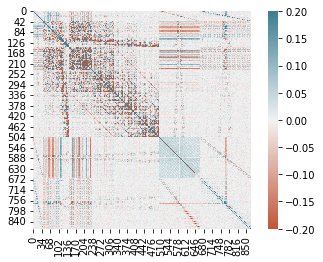

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns


# 计算Spearman相关性系数
corr_matrix = pd.DataFrame(trainData_com).corr(method='spearman')

# 绘制热力图
sns.heatmap(corr_matrix, vmin=-0.2, vmax=0.2, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.savefig("Result/Composition_Spearman.jpg",dpi=300)

In [113]:
data = np.array(corr_matrix)
bl = []
for i,_ in enumerate(data):
    if False not in np.isnan(data[i,:]):
        bl.append(False)
    else:
        bl.append(True)
bl = np.array(bl)

In [114]:
data = np.delete(data, np.where(~bl)[0], axis=0)

In [115]:
bl = []
for i,_ in enumerate(data):
    if False not in np.isnan(data[:,i]):
        bl.append(False)
    else:
        bl.append(True)
bl = np.array(bl)

In [116]:
data = np.delete(data, np.where(~bl)[0], axis=1)

In [117]:
data = pd.DataFrame(data)
nan_cols = data.isna().all()

# 将布尔型DataFrame转换为列表
nan_cols_list = list(nan_cols[nan_cols].index)

# 删除包含NaN值的列
data.drop(nan_cols_list, axis=1, inplace=True)

In [118]:
data.shape

(333, 333)

In [109]:



# 计算矩阵绝对值的均值
mean_abs = np.mean(np.abs(data))
print("Mean absolute value of the matrix: ", mean_abs)

Mean absolute value of the matrix:  0      0.019767
1      0.022105
2      0.023683
3      0.023654
4      0.024488
         ...   
854    0.017459
855    0.019282
856    0.015268
857    0.017563
858    0.016080
Length: 859, dtype: float64


In [82]:
np.mean(mean_abs)

0.035349263223162834

In [93]:
np.mean(mean_abs)

0.07712384913117712

In [120]:
np.mean(np.mean(np.abs(data.iloc[:-20,:-20])))

0.057661813874183655

In [110]:
np.mean(mean_abs)

0.036100870399290996